In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MovieLens-100K

In [ ]:
"""
Feature Subspace Transfer Deep Matrix Factorization (FSTDMF)
------------------------------------------------------------
Full implementation + helpers + optional grid-search.
Now logs **RMSE and MAE** everywhere.
"""

from __future__ import annotations
import math, random, dataclasses
from dataclasses import dataclass
from typing import Iterable, List, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────
# 1) DATA HELPERS
# ──────────────────────────────────────────────────────────────
def _build_index(triples:Iterable[Tuple[int,int,float]]):
    users,items=zip(*[(u,i) for u,i,_ in triples]); return max(users)+1,max(items)+1

class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, triples:List[Tuple[int,int,float]],
                 num_users:int|None=None, num_items:int|None=None):
        self.triples=triples
        self.num_users,self.num_items= ( _build_index(triples) if num_users is None else (num_users,num_items) )
    def __len__(self): return len(self.triples)
    def __getitem__(self,idx:int):
        u,i,r=self.triples[idx]
        return (torch.tensor(u,dtype=torch.long),
                torch.tensor(i,dtype=torch.long),
                torch.tensor(r,dtype=torch.float32))

def batchify(loader, device=DEVICE):
    for u,i,r in loader:
        yield u.to(device), i.to(device), r.to(device)

# ──────────────────────────────────────────────────────────────
# 2) CONFIG
# ──────────────────────────────────────────────────────────────
@dataclass(slots=True)
class Config:
    num_users:int; num_items:int
    lr_grid:Tuple[float,...]=(0.0123,0.00123)
    eta_grid:Tuple[float,...]=(0.10,0.15,0.20,0.25,0.30,0.35,0.40)
    dim_grid:Tuple[int,...]=(100,300,500)


    latent_dim:int=100; eta:float=1.0; batch_size:int=128; lr:float=0.0123
    hidden_dims:Tuple[int,int]=(256,128)
    beta:float=0.1; alpha:float=0.10
    epochs_pretrain:int=40; epochs:int=40; lr_pretrain:float=1e-3
    aux_va:torch.Tensor|None=None
    def copy(self,**kw): d=dataclasses.asdict(self); d.update(kw); return Config(**d)

# ──────────────────────────────────────────────────────────────
# 3) MODELS
# ──────────────────────────────────────────────────────────────
class SemiAutoEncoder(nn.Module):
    def __init__(self,input_dim:int, latent_dim:int, hidden_dim:int|None=None):
        super().__init__()
        hidden_dim=hidden_dim or latent_dim*2
        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim), nn.Sigmoid(),
                                   nn.Linear(hidden_dim,latent_dim))
        self.decoder=nn.Linear(latent_dim,input_dim)
    def forward(self,x):
        z=self.encoder(x); x_hat=self.decoder(z); return x_hat,z

class DeepMF(nn.Module):
    def __init__(self,cfg:Config):
        super().__init__()
        self.user=nn.Embedding(cfg.num_users,cfg.latent_dim)
        self.item=nn.Embedding(cfg.num_items,cfg.latent_dim)
        dims=[cfg.latent_dim*2]+list(cfg.hidden_dims)+[1]
        layers=[]
        for d_in,d_out in zip(dims[:-1],dims[1:]):
            layers.append(nn.Linear(d_in,d_out));
            if d_out!=1: layers.append(nn.Tanh())
        self.mlp=nn.Sequential(*layers)
    def forward(self,u,i):
        u_vec=self.user(u); v_vec=self.item(i)
        pred=self.mlp(torch.cat([u_vec,v_vec],-1)).squeeze(-1)
        return pred,u_vec,v_vec

class FSTDMF(nn.Module):
    def __init__(self, cfg: Config, n_ratings: int, V_init: torch.Tensor | None = None):
        super().__init__()
        self.cfg = cfg
        self.dmf = DeepMF(cfg)
        self.n = n_ratings
        if V_init is not None:
            with torch.no_grad():
                self.dmf.item.weight.copy_(V_init)
        if cfg.aux_va is not None:
            self.register_buffer("aux_va", cfg.aux_va)
            self.register_buffer("P_aux", self.aux_va @ self.aux_va.T)
        else:
            self.aux_va = None
            self.P_aux = None

    def rec_loss(self,pred_full, target_full, mask):
        return ((pred_full - target_full) * mask).pow(2).sum() / (2 * mask.shape[0])  # normalize by n_items

    def l2_loss(self, V):
        loss_V = (self.cfg.alpha / (2 * self.n)) * V.pow(2).sum()
        loss_W = (self.cfg.beta / 2) * sum(p.pow(2).sum() for p in self.parameters())
        return loss_V + loss_W

    def sub_loss(self, V):
        if self.aux_va is None:
            return torch.tensor(0., device=V.device)
        proj = self.P_aux @ V
        return -(self.cfg.alpha * self.cfg.eta) / (2 * self.n) * proj.pow(2).sum()

    def total_loss(self, R_hat, R_full, mask, V):
        return self.rec_loss(R_hat, R_full, mask) + self.sub_loss(V) + self.l2_loss(V)

    def forward(self, V):
        # Full prediction matrix R_hat ∈ [n_items, n_users]
        U = self.dmf.user.weight           # [n_users, d]
        I = self.dmf.item.weight           # [n_items, d]
        all_u = U.unsqueeze(0).expand(I.shape[0], -1, -1)  # [n_items, n_users, d]
        all_i = I.unsqueeze(1).expand(-1, U.shape[0], -1)  # [n_items, n_users, d]
        concat = torch.cat([all_u, all_i], dim=-1)         # [n_items, n_users, 2d]
        R_hat = self.dmf.mlp(concat).squeeze(-1)           # [n_items, n_users]
        return R_hat




# ──────────────────────────────────────────────────────────────
# 4) TRAIN / EVAL (RMSE & MAE)   <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _epoch_metrics(se_sum:float, ae_sum:float, n:int)->Tuple[float,float]:
    rmse=math.sqrt(se_sum/n); mae=ae_sum/n; return rmse,mae

def pretrain_semiautoencoder(cfg:Config, dense:torch.Tensor):
    sa=SemiAutoEncoder(cfg.num_users,cfg.latent_dim,cfg.latent_dim*2).to(DEVICE)
    opt=torch.optim.Adam(sa.parameters(), lr=cfg.lr_pretrain)
    X=dense.to(DEVICE)
    for ep in range(cfg.epochs_pretrain):
        opt.zero_grad(); x_hat,_=sa(X.T)
        loss=F.mse_loss(x_hat,X.T); loss.backward(); opt.step()
        if (ep+1)%10==0: print(f"[SA] Ep {ep+1}/{cfg.epochs_pretrain}  Loss={loss.item():.4f}")
    with torch.no_grad(): _ ,V=sa(X.T); return V.cpu()


def train_fstdmf(cfg: Config, ds: RatingDataset, V_init: torch.Tensor | None):
    model = FSTDMF(cfg, len(ds), V_init).to(DEVICE)
    V = nn.Parameter(V_init.clone().to(DEVICE))  # ← make item embeddings a parameter
    opt = torch.optim.Rprop([*model.parameters(), V], lr=cfg.lr,
                            etas=(0.5, 1.2), step_sizes=(1e-6, 50))

    # Build full rating matrix and mask
    R_full = torch.zeros(cfg.num_items, cfg.num_users, device=DEVICE)
    mask_tr = torch.zeros_like(R_full)
    for u, i, r in ds.triples:
        R_full[i, u] = r
        mask_tr[i, u] = 1.0

    rmses, maes = [], []
    for ep in range(cfg.epochs):
        model.train(); opt.zero_grad()
        model.dmf.item.weight = V  # tie to parameter

        R_hat = model(V)
        loss = model.total_loss(R_hat, R_full, mask_tr, V)
        loss.backward(); opt.step()

        # Metrics
        se = ((R_hat - R_full) * mask_tr).pow(2).sum().item()
        ae = ((R_hat - R_full).abs() * mask_tr).sum().item()
        n = mask_tr.sum().item()
        rmse, mae = _epoch_metrics(se, ae, n)
        rmses.append(rmse); maes.append(mae)

        if (ep + 1) % 10 == 0:
            print(f"[FSTDMF] Ep {ep + 1}/{cfg.epochs}  RMSE≈{rmse:.4f} | MAE≈{mae:.4f}")

    # Plot
    plt.figure()
    plt.plot(range(1, cfg.epochs + 1), rmses, label="RMSE")
    plt.plot(range(1, cfg.epochs + 1), maes, label="MAE")
    plt.xlabel("Epoch"); plt.ylabel("Error")
    plt.title("Training RMSE and MAE per Epoch")
    plt.legend(); plt.show()


    return model, V


@torch.no_grad()
def evaluate_metrics(model: FSTDMF, ds: RatingDataset, V: torch.Tensor) -> Tuple[float, float]:
    model.eval()
    R_hat = model(V.to(DEVICE))  # shape [n_items, n_users]
    se, ae, n = 0., 0., 0
    for u, i, r in ds.triples:
        pred = R_hat[i, u].item()
        se += (pred - r) ** 2
        ae += abs(pred - r)
        n += 1
    return _epoch_metrics(se, ae, n)


# ──────────────────────────────────────────────────────────────
# 5) SINGLE RUN  (random or fixed)  <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _pick(t): return random.choice(t)
def run_once(cfg_base: Config, ds: RatingDataset, dense: torch.Tensor,
             cfg_override: Config | None = None):
    cfg = cfg_override or cfg_base.copy(
        lr=_pick(cfg_base.lr_grid),
        eta=1.0,
        batch_size=128
    )
    print(f"[run-once] cfg → {cfg}")
    V_init = pretrain_semiautoencoder(cfg, dense)
    model, V = train_fstdmf(cfg, ds, V_init)  # ⬅️ return both model and final V

    rmse, mae = evaluate_metrics(model, ds, V)
    print(f"[run-once] Train-set  RMSE={rmse:.4f} | MAE={mae:.4f}")
    return cfg, model, V, rmse, mae





✓ MovieLens-100K extracted
Aux-feature dimension = 32

=== split 70% train  ===
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(32,), batch_grid=(32, 64, 128, 256, 512), latent_dim=32, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-5.2143e-07,  1.1874e-07, -1.6540e-07,  ...,  6.4762e-03,
         -1.6014e-02, -1.9361e-02],
        [ 4.8167e-07, -6.3119e-02, -6.6083e-02,  ...,  6.0611e-03,
         -1.3744e-02, -2.5585e-03],
        [ 8.6029e-07,  2.9920e-08, -5.7987e-08,  ..., -4.4216e-03,
         -2.2829e-03,  4.0991e-02],
        ...,
        [ 3.9374e-07, -3.9936e-08,  6.3772e-08,  ...,  3.7653e-03,
         -1.2270e-02,  9.5516e-04],
        [ 1.1893e-06, -2.4338e-08,  1.2410e-07,  ...,  1.1433e-03,
         -8.3014e-03,  2.5394e-02],
        [-7.5776e-08,  8.9515e-08, -9.2940e-08,  ...,  4

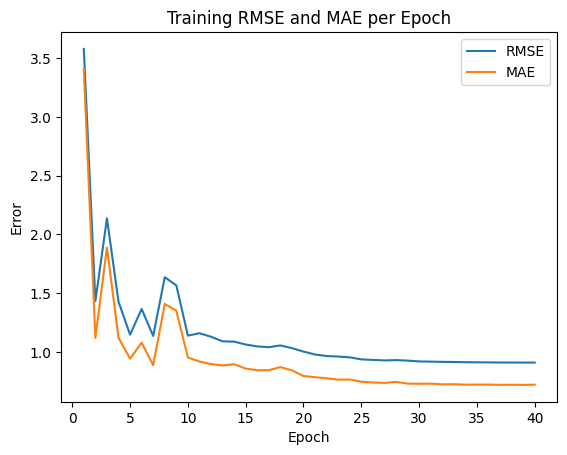

[run-once] Train-set  RMSE=0.9118 | MAE=0.7196
Train  RMSE=0.9118 | MAE=0.7196
Test   RMSE=0.9506 | MAE=0.7499

=== split 50% train  ===
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(32,), batch_grid=(32, 64, 128, 256, 512), latent_dim=32, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-5.2143e-07,  1.1874e-07, -1.6540e-07,  ...,  6.4762e-03,
         -1.6014e-02, -1.9361e-02],
        [ 4.8167e-07, -6.3119e-02, -6.6083e-02,  ...,  6.0611e-03,
         -1.3744e-02, -2.5585e-03],
        [ 8.6029e-07,  2.9920e-08, -5.7987e-08,  ..., -4.4216e-03,
         -2.2829e-03,  4.0991e-02],
        ...,
        [ 3.9374e-07, -3.9936e-08,  6.3772e-08,  ...,  3.7653e-03,
         -1.2270e-02,  9.5516e-04],
        [ 1.1893e-06, -2.4338e-08,  1.2410e-07,  ...,  1.1433e-03,
         -8.3014e-03,  2.5394e-02],

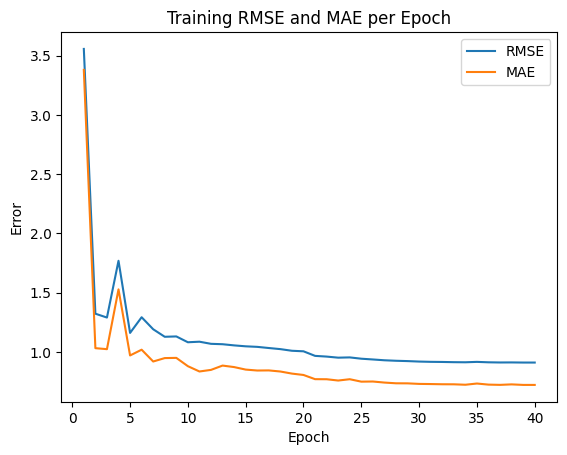

[run-once] Train-set  RMSE=0.9090 | MAE=0.7217
Train  RMSE=0.9090 | MAE=0.7217
Test   RMSE=0.9528 | MAE=0.7570

=== split 30% train  ===
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(32,), batch_grid=(32, 64, 128, 256, 512), latent_dim=32, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-5.2143e-07,  1.1874e-07, -1.6540e-07,  ...,  6.4762e-03,
         -1.6014e-02, -1.9361e-02],
        [ 4.8167e-07, -6.3119e-02, -6.6083e-02,  ...,  6.0611e-03,
         -1.3744e-02, -2.5585e-03],
        [ 8.6029e-07,  2.9920e-08, -5.7987e-08,  ..., -4.4216e-03,
         -2.2829e-03,  4.0991e-02],
        ...,
        [ 3.9374e-07, -3.9936e-08,  6.3772e-08,  ...,  3.7653e-03,
         -1.2270e-02,  9.5516e-04],
        [ 1.1893e-06, -2.4338e-08,  1.2410e-07,  ...,  1.1433e-03,
         -8.3014e-03,  2.5394e-02],

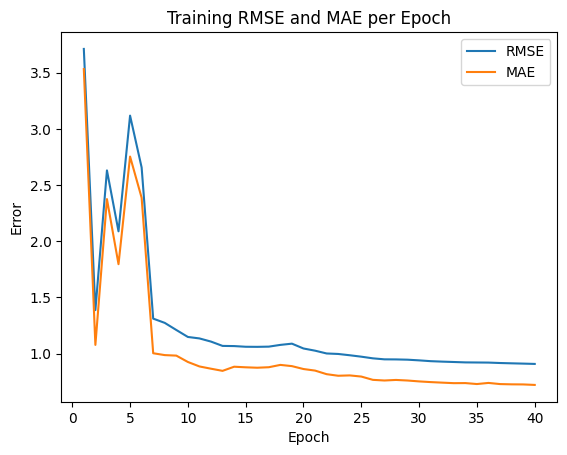

[run-once] Train-set  RMSE=0.9048 | MAE=0.7178
Train  RMSE=0.9048 | MAE=0.7178
Test   RMSE=0.9599 | MAE=0.7606


In [ ]:

# ============================================================
# MovieLens-100K  |  three train-fractions (0.7 / 0.5 / 0.3)
# ============================================================
from pathlib import Path
import pandas as pd, numpy as np, torch, zipfile, random, math

# ---------- 0) extract dataset ------------------------------------------------
BASE = Path("/content/drive/MyDrive/Colab Notebooks/bigdata/project")
zip_path, data_dir = BASE / "ml-100k.zip", BASE / "ml-100k"
if not data_dir.exists():
    with zipfile.ZipFile(zip_path) as zf: zf.extractall(BASE)
print("✓ MovieLens-100K extracted")

# ---------- 1) ratings & attributes ------------------------------------------
ratings = pd.read_csv(data_dir / "u.data", sep="\t",
                      names=["user", "item", "rating", "ts"])
ratings[["user", "item"]] -= 1

item = pd.read_csv(
    data_dir / "u.item", sep="|", header=None, encoding="latin-1",
    names=["item_id","title","release","video","imdb"] + [f"g{i}" for i in range(19)]
)
item["item_id"] -= 1
item["year"] = pd.to_datetime(item["release"], errors="coerce").dt.year.fillna(1990).astype(int)

# ---------- 2) one-hot matrix C  (genre + 7-year bins) ------------------------
n_items = item["item_id"].max()+1
genre = item.set_index("item_id")[ [f"g{i}" for i in range(19)] ] \
            .reindex(range(n_items), fill_value=0).values

def ybin(y, base=1910, span=7): return (y-base)//span
bins   = ybin(item["year"].values)
Ymax   = bins.max()
yr_hot = np.zeros((n_items, Ymax+1), np.float32)
yr_hot[np.arange(n_items), bins] = 1
C = np.hstack([genre, yr_hot])

# ---------- 3) orthogonalise  C → VA  ----------------------------------------
Q,_ = np.linalg.qr(C + 1e-6*np.random.randn(*C.shape))
VA  = torch.tensor(Q.astype(np.float32))
d_aux = VA.shape[1]
print(f"Aux-feature dimension = {d_aux}")

# ---------- 4) triples + dense rating matrix ---------------------------------
triples = list(zip(ratings.user, ratings.item, ratings.rating))

full_ds = RatingDataset(triples)
dense = torch.zeros(full_ds.num_users, full_ds.num_items)
for u,i,r in triples: dense[u,i]=r

# ---------- helper: create split, run model, print metrics --------------------
def run_fraction(train_frac: float, seed: int = 42):
    print(f"\n=== split {int(train_frac * 100)}% train  ===")
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(full_ds))
    k = int(train_frac * len(full_ds))
    tr_idx, te_idx = perm[:k], perm[k:]
    tr = RatingDataset([full_ds.triples[i] for i in tr_idx],
                       full_ds.num_users, full_ds.num_items)
    te = RatingDataset([full_ds.triples[i] for i in te_idx],
                       full_ds.num_users, full_ds.num_items)

    # cfg locked to d_aux
    cfg0 = Config(num_users=tr.num_users, num_items=tr.num_items,
                  aux_va=VA, latent_dim=d_aux, dim_grid=(d_aux,))

    cfg, model, V, rmse_tr, mae_tr = run_once(cfg0, tr, dense)
    rmse_te, mae_te = evaluate_metrics(model, te, V)  # ⬅️ now passes V

    print(f"Train  RMSE={rmse_tr:.4f} | MAE={mae_tr:.4f}")
    print(f"Test   RMSE={rmse_te:.4f} | MAE={mae_te:.4f}")
    return (rmse_te, mae_te)

# ---------- 5) run for 70%, 50%, 30% -----------------------------------------
for frac in (0.7, 0.5, 0.3):
    run_fraction(frac)


# Movielens-100k grid search

In [ ]:
"""
Feature Subspace Transfer Deep Matrix Factorization (FSTDMF)
------------------------------------------------------------
Full implementation + helpers + optional grid-search.
Now logs **RMSE and MAE** everywhere.
"""

from __future__ import annotations
import math, random, dataclasses
from dataclasses import dataclass
from typing import Iterable, List, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────
# 1) DATA HELPERS
# ──────────────────────────────────────────────────────────────
def _build_index(triples:Iterable[Tuple[int,int,float]]):
    users,items=zip(*[(u,i) for u,i,_ in triples]); return max(users)+1,max(items)+1

class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, triples:List[Tuple[int,int,float]],
                 num_users:int|None=None, num_items:int|None=None):
        self.triples=triples
        self.num_users,self.num_items= ( _build_index(triples) if num_users is None else (num_users,num_items) )
    def __len__(self): return len(self.triples)
    def __getitem__(self,idx:int):
        u,i,r=self.triples[idx]
        return (torch.tensor(u,dtype=torch.long),
                torch.tensor(i,dtype=torch.long),
                torch.tensor(r,dtype=torch.float32))

def batchify(loader, device=DEVICE):
    for u,i,r in loader:
        yield u.to(device), i.to(device), r.to(device)

# ──────────────────────────────────────────────────────────────
# 2) CONFIG
# ──────────────────────────────────────────────────────────────
@dataclass(slots=True)
class Config:
    num_users:int; num_items:int
    lr_grid:Tuple[float,...]=(0.0123,0.00123)
    beta_grid:Tuple[float,...]=(0.15,0.40)
    alpha_grid:Tuple[float,...]=(0.10,0.20)
    dim_grid:Tuple[int,...]=(100,300)


    latent_dim:int=100; eta:float=1.0; batch_size:int=128; lr:float=0.0123
    hidden_dims:Tuple[int,int]=(256,128)
    beta:float=0.1; alpha:float=0.10
    epochs_pretrain:int=40; epochs:int=40; lr_pretrain:float=1e-3
    aux_va:torch.Tensor|None=None
    def copy(self,**kw): d=dataclasses.asdict(self); d.update(kw); return Config(**d)

# ──────────────────────────────────────────────────────────────
# 3) MODELS
# ──────────────────────────────────────────────────────────────
class SemiAutoEncoder(nn.Module):
    def __init__(self,input_dim:int, latent_dim:int, hidden_dim:int|None=None):
        super().__init__()
        hidden_dim=hidden_dim or latent_dim*2
        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim), nn.Sigmoid(),
                                   nn.Linear(hidden_dim,latent_dim))
        self.decoder=nn.Linear(latent_dim,input_dim)
    def forward(self,x):
        z=self.encoder(x); x_hat=self.decoder(z); return x_hat,z

class DeepMF(nn.Module):
    def __init__(self,cfg:Config):
        super().__init__()
        self.user=nn.Embedding(cfg.num_users,cfg.latent_dim)
        self.item=nn.Embedding(cfg.num_items,cfg.latent_dim)
        dims=[cfg.latent_dim*2]+list(cfg.hidden_dims)+[1]
        layers=[]
        for d_in,d_out in zip(dims[:-1],dims[1:]):
            layers.append(nn.Linear(d_in,d_out));
            if d_out!=1: layers.append(nn.Tanh())
        self.mlp=nn.Sequential(*layers)
    def forward(self,u,i):
        u_vec=self.user(u); v_vec=self.item(i)
        pred=self.mlp(torch.cat([u_vec,v_vec],-1)).squeeze(-1)
        return pred,u_vec,v_vec

class FSTDMF(nn.Module):
    def __init__(self, cfg: Config, n_ratings: int, V_init: torch.Tensor | None = None):
        super().__init__()
        self.cfg = cfg
        self.dmf = DeepMF(cfg)
        self.n = n_ratings
        if V_init is not None:
            with torch.no_grad():
                self.dmf.item.weight.copy_(V_init)
        if cfg.aux_va is not None:
            self.register_buffer("aux_va", cfg.aux_va)
            self.register_buffer("P_aux", self.aux_va @ self.aux_va.T)
        else:
            self.aux_va = None
            self.P_aux = None

    def rec_loss(self,pred_full, target_full, mask):
        return ((pred_full - target_full) * mask).pow(2).sum() / (2 * mask.shape[0])  # normalize by n_items

    def l2_loss(self, V):
        loss_V = (self.cfg.alpha / (2 * self.n)) * V.pow(2).sum()
        loss_W = (self.cfg.beta / 2) * sum(p.pow(2).sum() for p in self.parameters())
        return loss_V + loss_W

    def sub_loss(self, V):
        if self.aux_va is None:
            return torch.tensor(0., device=V.device)
        proj = self.P_aux @ V
        return -(self.cfg.alpha * self.cfg.eta) / (2 * self.n) * proj.pow(2).sum()

    def total_loss(self, R_hat, R_full, mask, V):
        return self.rec_loss(R_hat, R_full, mask) + self.sub_loss(V) + self.l2_loss(V)

    def forward(self, V):
        # Full prediction matrix R_hat ∈ [n_items, n_users]
        U = self.dmf.user.weight           # [n_users, d]
        I = self.dmf.item.weight           # [n_items, d]
        all_u = U.unsqueeze(0).expand(I.shape[0], -1, -1)  # [n_items, n_users, d]
        all_i = I.unsqueeze(1).expand(-1, U.shape[0], -1)  # [n_items, n_users, d]
        concat = torch.cat([all_u, all_i], dim=-1)         # [n_items, n_users, 2d]
        R_hat = self.dmf.mlp(concat).squeeze(-1)           # [n_items, n_users]
        return R_hat




# ──────────────────────────────────────────────────────────────
# 4) TRAIN / EVAL (RMSE & MAE)   <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _epoch_metrics(se_sum:float, ae_sum:float, n:int)->Tuple[float,float]:
    rmse=math.sqrt(se_sum/n); mae=ae_sum/n; return rmse,mae

def pretrain_semiautoencoder(cfg:Config, dense:torch.Tensor):
    sa=SemiAutoEncoder(cfg.num_users,cfg.latent_dim,cfg.latent_dim*2).to(DEVICE)
    opt=torch.optim.Adam(sa.parameters(), lr=cfg.lr_pretrain)
    X=dense.to(DEVICE)
    for ep in range(cfg.epochs_pretrain):
        opt.zero_grad(); x_hat,_=sa(X.T)
        loss=F.mse_loss(x_hat,X.T); loss.backward(); opt.step()
        if (ep+1)%10==0: print(f"[SA] Ep {ep+1}/{cfg.epochs_pretrain}  Loss={loss.item():.4f}")
    with torch.no_grad(): _ ,V=sa(X.T); return V.cpu()


def train_fstdmf(cfg: Config, ds: RatingDataset, V_init: torch.Tensor | None):
    model = FSTDMF(cfg, len(ds), V_init).to(DEVICE)
    V = nn.Parameter(V_init.clone().to(DEVICE))  # ← make item embeddings a parameter
    opt = torch.optim.Rprop([*model.parameters(), V], lr=cfg.lr,
                            etas=(0.5, 1.2), step_sizes=(1e-6, 50))

    # Build full rating matrix and mask
    R_full = torch.zeros(cfg.num_items, cfg.num_users, device=DEVICE)
    mask_tr = torch.zeros_like(R_full)
    for u, i, r in ds.triples:
        R_full[i, u] = r
        mask_tr[i, u] = 1.0

    rmses, maes = [], []
    for ep in range(cfg.epochs):
        model.train(); opt.zero_grad()
        model.dmf.item.weight = V  # tie to parameter

        R_hat = model(V)
        loss = model.total_loss(R_hat, R_full, mask_tr, V)
        loss.backward(); opt.step()

        # Metrics
        se = ((R_hat - R_full) * mask_tr).pow(2).sum().item()
        ae = ((R_hat - R_full).abs() * mask_tr).sum().item()
        n = mask_tr.sum().item()
        rmse, mae = _epoch_metrics(se, ae, n)
        rmses.append(rmse); maes.append(mae)

        if (ep + 1) % 10 == 0:
            print(f"[FSTDMF] Ep {ep + 1}/{cfg.epochs}  RMSE≈{rmse:.4f} | MAE≈{mae:.4f}")
    return model, V, rmses, maes


@torch.no_grad()
def evaluate_metrics(model: FSTDMF, ds: RatingDataset, V: torch.Tensor) -> Tuple[float, float]:
    model.eval()
    R_hat = model(V.to(DEVICE))  # shape [n_items, n_users]
    se, ae, n = 0., 0., 0
    for u, i, r in ds.triples:
        pred = R_hat[i, u].item()
        se += (pred - r) ** 2
        ae += abs(pred - r)
        n += 1
    return _epoch_metrics(se, ae, n)


# ──────────────────────────────────────────────────────────────
# 5) SINGLE RUN  (random or fixed)  <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _pick(t): return random.choice(t)
def run_once(cfg_base: Config, ds: RatingDataset, dense: torch.Tensor,
             cfg_override: Config | None = None):
    cfg = cfg_override or cfg_base.copy(
        lr=_pick(cfg_base.lr_grid),
        eta=1.0,
        batch_size=128
    )
    print(f"[run-once] cfg → {cfg}")
    V_init = pretrain_semiautoencoder(cfg, dense)
    model, V, rmses, maes = train_fstdmf(cfg, ds, V_init)

    rmse, mae = evaluate_metrics(model, ds, V)
    print(f"[run-once] Train-set  RMSE={rmse:.4f} | MAE={mae:.4f}")
    return cfg, model, V, rmse, mae
def run_once(cfg_base: Config, ds: RatingDataset, dense: torch.Tensor,
             cfg_override: Config | None = None):

    cfg = cfg_override or cfg_base
    print(f"[run-once] cfg → {cfg}")

    V_init = pretrain_semiautoencoder(cfg, dense)
    model, V, rmses, maes = train_fstdmf(cfg, ds, V_init)   # ✱ CHANGE


    # گزارش اختیاری از اپوک آخر
    print(f"[run-once] Last‑epoch RMSE={rmses[-1]:.4f} | MAE={maes[-1]:.4f}")  # ✱ CHANGE

    # 2️⃣  ← پنج‌تایی برگردان: … , rmses, maes
    return cfg, model, V, rmses, maes

# ------------------------------------------------------------
#   key = train_%   value = (trainval_share , inner_train_ratio)
# ------------------------------------------------------------
SPLITS = {
    0.70: (0.80, 0.90),   # 0.8 کل → 0.8*0.9 = 0.72 ≈ 70 % train
    0.50: (0.60, 0.85),   # 0.6 کل → 0.6*0.85 = 0.51 ≈ 50 % train
    0.30: (0.50, 0.60)    # 0.5 کل → 0.5*0.6 = 0.30 train
}
from itertools import product

def grid_search(cfg_base, tr_ds, val_ds, dense_tr):


    best_rmse, best = float("inf"), None

    for lr, beta, alpha, dim in product(cfg_base.lr_grid,
                                        cfg_base.beta_grid,
                                        cfg_base.alpha_grid,
                                        cfg_base.dim_grid):


        cfg_try = cfg_base.copy(lr=lr, beta=beta,
                                alpha=alpha, latent_dim=dim)



        print(f"[GRID] lr={lr:.5f}  beta={beta:.2f}  alpha={alpha:.2f}  d={dim}")
        cfg_try, model, V, rmses, maes = run_once(cfg_base, tr_ds, dense_tr, cfg_try)  # ✱ CHANGE
        rmse_val, _ = evaluate_metrics(model, val_ds, V)
        print(f"[GRID] ➜ RMSE_val = {rmse_val:.4f}")

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best      = (cfg_try, model, V, rmses, maes)   # لیست‌ها را هم ذخیره کن
       # (cfg, model, V)
    print(f"\n>>> Best on validation = {best_rmse:.4f}"
          f"  (lr={best[0].lr:.5f}, beta={best[0].beta:.2f}, "
          f"alpha={best[0].alpha:.2f}, d={best[0].latent_dim})")
    return best



✓ MovieLens-100K extracted
Aux-feature dimension = 32
[GRID] lr=0.01230  beta=0.15  alpha=0.10  d=100
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), beta_grid=(0.15, 0.4), alpha_grid=(0.1, 0.2), dim_grid=(100, 300), latent_dim=100, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.15, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-1.4113e-06,  5.6972e-08,  4.3436e-08,  ...,  3.5480e-03,
         -1.6320e-02, -1.9479e-02],
        [-1.0385e-06, -6.3119e-02,  6.6083e-02,  ...,  5.9658e-03,
         -1.3674e-02, -2.5244e-03],
        [ 2.0720e-07, -1.2360e-07, -1.6879e-07,  ..., -2.7268e-03,
         -2.6778e-03,  4.0787e-02],
        ...,
        [ 9.8130e-07,  8.2424e-08,  1.0593e-07,  ...,  5.7421e-03,
         -1.1880e-02,  1.1215e-03],
        [ 7.1861e-07, -8.7064e-10, -1.5185e-07,  ...,  1.6339e-03,
         -8.6538e-03,  2.5221e-02],
        [-6.2083e-07, -4.8822e-08, -1.2962e-07,  ...,  5.6078e-03,

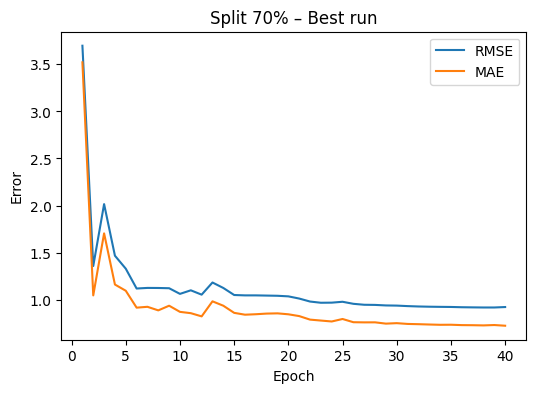

[GRID] lr=0.01230  beta=0.15  alpha=0.10  d=100
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), beta_grid=(0.15, 0.4), alpha_grid=(0.1, 0.2), dim_grid=(100, 300), latent_dim=100, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.15, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-1.4113e-06,  5.6972e-08,  4.3436e-08,  ...,  3.5480e-03,
         -1.6320e-02, -1.9479e-02],
        [-1.0385e-06, -6.3119e-02,  6.6083e-02,  ...,  5.9658e-03,
         -1.3674e-02, -2.5244e-03],
        [ 2.0720e-07, -1.2360e-07, -1.6879e-07,  ..., -2.7268e-03,
         -2.6778e-03,  4.0787e-02],
        ...,
        [ 9.8130e-07,  8.2424e-08,  1.0593e-07,  ...,  5.7421e-03,
         -1.1880e-02,  1.1215e-03],
        [ 7.1861e-07, -8.7064e-10, -1.5185e-07,  ...,  1.6339e-03,
         -8.6538e-03,  2.5221e-02],
        [-6.2083e-07, -4.8822e-08, -1.2962e-07,  ...,  5.6078e-03,
         -9.9816e-03,  2.0134e-02]]))
[SA] Ep 10/40  

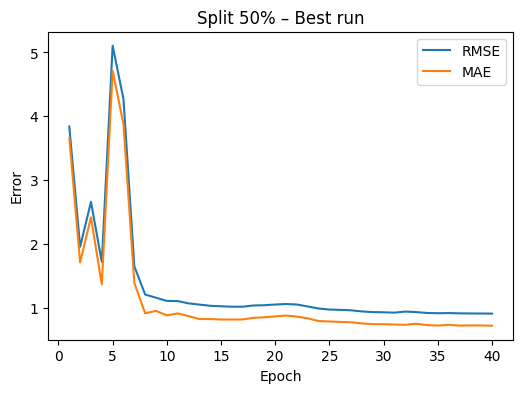

[GRID] lr=0.01230  beta=0.15  alpha=0.10  d=100
[run-once] cfg → Config(num_users=943, num_items=1682, lr_grid=(0.0123, 0.00123), beta_grid=(0.15, 0.4), alpha_grid=(0.1, 0.2), dim_grid=(100, 300), latent_dim=100, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.15, alpha=0.1, epochs_pretrain=40, epochs=40, lr_pretrain=0.001, aux_va=tensor([[-1.4113e-06,  5.6972e-08,  4.3436e-08,  ...,  3.5480e-03,
         -1.6320e-02, -1.9479e-02],
        [-1.0385e-06, -6.3119e-02,  6.6083e-02,  ...,  5.9658e-03,
         -1.3674e-02, -2.5244e-03],
        [ 2.0720e-07, -1.2360e-07, -1.6879e-07,  ..., -2.7268e-03,
         -2.6778e-03,  4.0787e-02],
        ...,
        [ 9.8130e-07,  8.2424e-08,  1.0593e-07,  ...,  5.7421e-03,
         -1.1880e-02,  1.1215e-03],
        [ 7.1861e-07, -8.7064e-10, -1.5185e-07,  ...,  1.6339e-03,
         -8.6538e-03,  2.5221e-02],
        [-6.2083e-07, -4.8822e-08, -1.2962e-07,  ...,  5.6078e-03,
         -9.9816e-03,  2.0134e-02]]))
[SA] Ep 10/40  

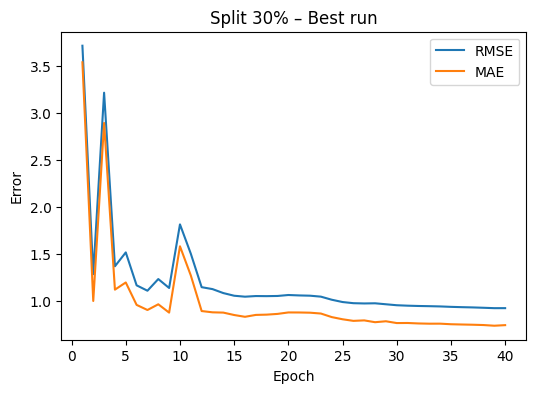

In [ ]:

# ============================================================
# MovieLens-100K  |  three train-fractions (0.7 / 0.5 / 0.3)
# ============================================================
from pathlib import Path
import pandas as pd, numpy as np, torch, zipfile, random, math

# ---------- 0) extract dataset ------------------------------------------------
BASE = Path("/content/drive/MyDrive/Colab Notebooks/bigdata/project")
zip_path, data_dir = BASE / "ml-100k.zip", BASE / "ml-100k"
if not data_dir.exists():
    with zipfile.ZipFile(zip_path) as zf: zf.extractall(BASE)
print("✓ MovieLens-100K extracted")

# ---------- 1) ratings & attributes ------------------------------------------
ratings = pd.read_csv(data_dir / "u.data", sep="\t",
                      names=["user", "item", "rating", "ts"])
ratings[["user", "item"]] -= 1

item = pd.read_csv(
    data_dir / "u.item", sep="|", header=None, encoding="latin-1",
    names=["item_id","title","release","video","imdb"] + [f"g{i}" for i in range(19)]
)
item["item_id"] -= 1
item["year"] = pd.to_datetime(item["release"], errors="coerce").dt.year.fillna(1990).astype(int)

# ---------- 2) one-hot matrix C  (genre + 7-year bins) ------------------------
n_items = item["item_id"].max()+1
genre = item.set_index("item_id")[ [f"g{i}" for i in range(19)] ] \
            .reindex(range(n_items), fill_value=0).values

def ybin(y, base=1910, span=7): return (y-base)//span
bins   = ybin(item["year"].values)
Ymax   = bins.max()
yr_hot = np.zeros((n_items, Ymax+1), np.float32)
yr_hot[np.arange(n_items), bins] = 1
C = np.hstack([genre, yr_hot])

# ---------- 3) orthogonalise  C → VA  ----------------------------------------
Q,_ = np.linalg.qr(C + 1e-6*np.random.randn(*C.shape))
VA  = torch.tensor(Q.astype(np.float32))
d_aux = VA.shape[1]
print(f"Aux-feature dimension = {d_aux}")

# ---------- 4) triples + dense rating matrix ---------------------------------
triples = list(zip(ratings.user, ratings.item, ratings.rating))

full_ds = RatingDataset(triples)
dense = torch.zeros(full_ds.num_users, full_ds.num_items)
for u,i,r in triples: dense[u,i]=r

# ---------- helper: create split, run model, print metrics --------------------
def run_fraction(train_frac: float, seed: int = 42):
    """train_frac = 0.70  یا 0.50 یا 0.30"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(full_ds))

    trainval_share, inner_ratio = SPLITS[train_frac]
    n = len(full_ds)
    n_trainval = int(trainval_share * n)
    n_train    = int(inner_ratio  * n_trainval)

    idx_train = perm[:n_train]
    idx_val   = perm[n_train:n_trainval]
    idx_test  = perm[n_trainval:]

    tr_ds  = RatingDataset([full_ds.triples[i] for i in idx_train],
                           full_ds.num_users, full_ds.num_items)
    val_ds = RatingDataset([full_ds.triples[i] for i in idx_val],
                           full_ds.num_users, full_ds.num_items)
    te_ds  = RatingDataset([full_ds.triples[i] for i in idx_test],
                           full_ds.num_users, full_ds.num_items)

    cfg0 = Config(num_users=tr_ds.num_users,
                  num_items=tr_ds.num_items,
                  aux_va=VA)

    best_cfg, best_model, best_V, rmses, maes = grid_search(cfg0, tr_ds, val_ds, dense)  # ✱ CHANGE


    # === FINAL TEST METRICS ===
    rmse_te, mae_te = evaluate_metrics(best_model, te_ds, best_V)
    print(f"\n=== FINAL (train {int(train_frac*100)}%) "
          f"RMSE_test={rmse_te:.4f} | MAE_test={mae_te:.4f}")
    print(f"    ↳ best params: lr={best_cfg.lr:.5f}, "
          f"beta={best_cfg.beta:.2f}, alpha={best_cfg.alpha:.2f}, "
          f"d={best_cfg.latent_dim}")

    # ---------- SINGLE PLOT for the BEST run ----------
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(rmses)+1), rmses, label="RMSE")
    plt.plot(range(1, len(maes)+1),  maes,  label="MAE")
    plt.xlabel("Epoch"); plt.ylabel("Error")
    plt.title(f"Split {int(train_frac*100)}% – Best run")
    plt.legend(); plt.show()




# ---------- 5) run for 70%, 50%, 30% -----------------------------------------
for frac in (0.7, 0.5, 0.3):
    run_fraction(frac)


# MovieLens-1M

In [ ]:
"""
Feature Subspace Transfer Deep Matrix Factorization (FSTDMF)
------------------------------------------------------------
Full implementation + helpers + optional grid-search.
Now logs **RMSE and MAE** everywhere.
"""

from __future__ import annotations
import math, random, dataclasses
from dataclasses import dataclass
from typing import Iterable, List, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────
# 1) DATA HELPERS
# ──────────────────────────────────────────────────────────────
def _build_index(triples:Iterable[Tuple[int,int,float]]):
    users,items=zip(*[(u,i) for u,i,_ in triples]); return max(users)+1,max(items)+1

class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, triples:List[Tuple[int,int,float]],
                 num_users:int|None=None, num_items:int|None=None):
        self.triples=triples
        self.num_users,self.num_items= ( _build_index(triples) if num_users is None else (num_users,num_items) )
    def __len__(self): return len(self.triples)
    def __getitem__(self,idx:int):
        u,i,r=self.triples[idx]
        return (torch.tensor(u,dtype=torch.long),
                torch.tensor(i,dtype=torch.long),
                torch.tensor(r,dtype=torch.float32))

def batchify(loader, device=DEVICE):
    for u,i,r in loader:
        yield u.to(device), i.to(device), r.to(device)

# ──────────────────────────────────────────────────────────────
# 2) CONFIG
# ──────────────────────────────────────────────────────────────
@dataclass(slots=True)
class Config:
    num_users:int; num_items:int
    lr_grid:Tuple[float,...]=(0.0123,0.00123)
    eta_grid:Tuple[float,...]=(0.10,0.15,0.20,0.25,0.30,0.35,0.40)
    dim_grid:Tuple[int,...]=(100,300,500)
    batch_grid:Tuple[int,...]=(32,64,128,256,512)


    latent_dim:int=100; eta:float=1.0; batch_size:int=128; lr:float=0.0123
    hidden_dims:Tuple[int,int]=(128,64)
    beta:float=0.1; alpha:float=0.10
    epochs_pretrain:int=40; epochs:int=50; lr_pretrain:float=1e-3
    aux_va:torch.Tensor|None=None
    def copy(self,**kw): d=dataclasses.asdict(self); d.update(kw); return Config(**d)

# ──────────────────────────────────────────────────────────────
# 3) MODELS
# ──────────────────────────────────────────────────────────────
class SemiAutoEncoder(nn.Module):
    def __init__(self,input_dim:int, latent_dim:int, hidden_dim:int|None=None):
        super().__init__()
        hidden_dim=hidden_dim or latent_dim*2
        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim), nn.Sigmoid(),
                                   nn.Linear(hidden_dim,latent_dim))
        self.decoder=nn.Linear(latent_dim,input_dim)
    def forward(self,x):
        z=self.encoder(x); x_hat=self.decoder(z); return x_hat,z

class DeepMF(nn.Module):
    def __init__(self,cfg:Config):
        super().__init__()
        self.user=nn.Embedding(cfg.num_users,cfg.latent_dim)
        self.item=nn.Embedding(cfg.num_items,cfg.latent_dim)
        dims=[cfg.latent_dim*2]+list(cfg.hidden_dims)+[1]
        layers=[]
        for d_in,d_out in zip(dims[:-1],dims[1:]):
            layers.append(nn.Linear(d_in,d_out));
            if d_out!=1: layers.append(nn.Tanh())
        self.mlp=nn.Sequential(*layers)
    def forward(self,u,i):
        u_vec=self.user(u); v_vec=self.item(i)
        pred=self.mlp(torch.cat([u_vec,v_vec],-1)).squeeze(-1)
        return pred,u_vec,v_vec

class FSTDMF(nn.Module):
    def __init__(self, cfg: Config, n_ratings: int, V_init: torch.Tensor | None = None):
        super().__init__()
        self.cfg = cfg
        self.dmf = DeepMF(cfg)
        self.n = n_ratings
        if V_init is not None:
            with torch.no_grad():
                self.dmf.item.weight.copy_(V_init)
        if cfg.aux_va is not None:
            self.register_buffer("aux_va", cfg.aux_va)
            self.register_buffer("P_aux", self.aux_va @ self.aux_va.T)
        else:
            self.aux_va = None
            self.P_aux = None

    def rec_loss(self,pred_full, target_full, mask):
        return ((pred_full - target_full) * mask).pow(2).sum() / (2 * mask.shape[0])  # normalize by n_items

    def l2_loss(self, V):
        loss_V = (self.cfg.alpha / (2 * self.n)) * V.pow(2).sum()
        loss_W = (self.cfg.beta / 2) * sum(p.pow(2).sum() for p in self.parameters())
        return loss_V + loss_W

    def sub_loss(self, V):
        if self.aux_va is None:
            return torch.tensor(0., device=V.device)
        proj = self.P_aux @ V
        return -(self.cfg.alpha * self.cfg.eta) / (2 * self.n) * proj.pow(2).sum()

    def total_loss(self, R_hat, R_full, mask, V):
        return self.rec_loss(R_hat, R_full, mask) + self.sub_loss(V) + self.l2_loss(V)

    # def forward(self, V, chunk_items: int = 512):
    #     U = self.dmf.user.weight           #  [n_users, d]
    #     R_hat_chunks = []                  #  accumulate pieces
    #     for start in range(0, V.size(0), chunk_items):
    #         I_chunk = V[start:start+chunk_items]        # [b, d]
    #         # ⬇️ اندازه‌ها: [b, n_users, d]
    #         u_rep  = U.expand(I_chunk.size(0), -1, -1)
    #         i_rep  = I_chunk.unsqueeze(1).expand(-1, U.size(0), -1)
    #         out    = self.dmf.mlp(torch.cat([u_rep, i_rep], -1)).squeeze(-1)
    #         R_hat_chunks.append(out)       #  [b, n_users]
    #     return torch.cat(R_hat_chunks, dim=0)
    def forward(self, u, i):
        u_vec = self.dmf.user(u)
        v_vec = self.dmf.item(i)
        return self.dmf.mlp(torch.cat([u_vec, v_vec], -1)).squeeze(-1)

    def predict_all(self, chunk_items: int | torch.Tensor = 512):
        chunk_items = int(chunk_items)                # ← تضمین می‌کند int باشد
        U = self.dmf.user.weight
        V = self.dmf.item.weight
        outs = []
        for s in range(0, V.size(0), chunk_items):
            Iv  = V[s : s + chunk_items]
            out = self.dmf.mlp(torch.cat([
                      U.expand(Iv.size(0), -1, -1),
                      Iv.unsqueeze(1).expand(-1, U.size(0), -1)
                  ], -1)).squeeze(-1)
            outs.append(out)
        return torch.cat(outs, 0)

    def predict_items(self, v_chunk):          # v_chunk: [b, d]
        U = self.dmf.user.weight               # [n_users, d]
        u_rep = U.expand(v_chunk.size(0), -1, -1)
        i_rep = v_chunk.unsqueeze(1).expand(-1, U.size(0), -1)
        return self.dmf.mlp(
            torch.cat([u_rep, i_rep], -1)
        ).squeeze(-1)



# ──────────────────────────────────────────────────────────────
# 4) TRAIN / EVAL (RMSE & MAE)   <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _epoch_metrics(se_sum:float, ae_sum:float, n:int)->Tuple[float,float]:
    rmse=math.sqrt(se_sum/n); mae=ae_sum/n; return rmse,mae

def pretrain_semiautoencoder(cfg:Config, dense:torch.Tensor):
    sa=SemiAutoEncoder(cfg.num_users,cfg.latent_dim,cfg.latent_dim*2).to(DEVICE)
    opt=torch.optim.Adam(sa.parameters(), lr=cfg.lr_pretrain)
    X=dense.to(DEVICE)
    for ep in range(cfg.epochs_pretrain):
        opt.zero_grad(); x_hat,_=sa(X.T)
        loss=F.mse_loss(x_hat,X.T); loss.backward(); opt.step()
        if (ep+1)%10==0: print(f"[SA] Ep {ep+1}/{cfg.epochs_pretrain}  Loss={loss.item():.4f}")
    with torch.no_grad(): _ ,V=sa(X.T); return V.cpu()


def train_full_chunk(cfg: Config, ds: RatingDataset, V_init):
    model = FSTDMF(cfg, len(ds), V_init).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    V = model.dmf.item.weight

    # build dense rating + mask once on GPU
    R_full = torch.zeros(cfg.num_items, cfg.num_users, device=DEVICE)
    mask = torch.zeros_like(R_full)
    for u, i, r in ds.triples:
        R_full[i, u] = r
        mask[i, u] = 1.0

    chunk = 1024  # items per chunk

    rmse_hist, mae_hist = [], []

    for ep in range(cfg.epochs):
        se = ae = 0.0
        for s in range(0, cfg.num_items, chunk):
            Vc = V[s:s + chunk]
            R_hat = model.predict_items(Vc)
            targ = R_full[s:s + chunk]
            msk = mask[s:s + chunk]

            rec = ((R_hat - targ) * msk).pow(2).sum() / (2 * cfg.num_items)
            loss = rec + model.sub_loss(V) + model.l2_loss(V)

            opt.zero_grad(); loss.backward(); opt.step()

            se += ((R_hat - targ) * msk).pow(2).sum().item()
            ae += ((R_hat - targ).abs() * msk).sum().item()

        rmse, mae = math.sqrt(se / len(ds)), ae / len(ds)
        rmse_hist.append(rmse)
        mae_hist.append(mae)

        if (ep + 1) % 10 == 0:
            print(f"[{ep+1}/{cfg.epochs}] RMSE={rmse:.4f} | MAE={mae:.4f}")

    # one‑shot plot
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, cfg.epochs + 1), rmse_hist, label="RMSE")
    plt.plot(range(1, cfg.epochs + 1), mae_hist, label="MAE")
    plt.xlabel("Epoch"); plt.ylabel("Error")
    plt.title("Training RMSE / MAE per Epoch")
    plt.legend(); plt.tight_layout(); plt.show()

    return model, V.detach().cpu()




@torch.no_grad()
def evaluate_metrics(model: FSTDMF, ds: RatingDataset, chunk_items: int = 512):
    model.eval()
    # ➊ ماتریس کامل را قطعه-قطعه می‌سازیم
    R_hat = model.predict_all(chunk_items)        # [n_items, n_users]
    # ➋ خطا روی سه‌تایی‌های دیده‌ شده
    se = ae = 0.0
    for u, i, r in ds.triples:
        pred = R_hat[i, u].item()
        se += (pred - r) ** 2
        ae += abs(pred - r)
    n = len(ds)
    return math.sqrt(se / n), ae / n



@torch.no_grad()
def evaluate_triplet(model: FSTDMF, ds: RatingDataset):
    se = ae = n = 0
    loader = torch.utils.data.DataLoader(ds, batch_size=4096)
    for u,i,r in batchify(loader):
        pred = model(u,i)
        se += ((pred-r)**2).sum().item()
        ae += (pred-r).abs().sum().item()
        n  += len(r)
    return math.sqrt(se/n), ae/n


# ──────────────────────────────────────────────────────────────
# 5) SINGLE RUN  (random or fixed)  <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _pick(t): return random.choice(t)
def run_once(cfg_base: Config, ds: RatingDataset, dense: torch.Tensor,
             cfg_override: Config | None = None):
    cfg = cfg_override or cfg_base.copy(
        lr=_pick(cfg_base.lr_grid),
        eta=1.0,
        batch_size=128
    )
    print(f"[run-once] cfg → {cfg}")
    V_init = pretrain_semiautoencoder(cfg, dense)
    model, V = train_full_chunk(cfg, ds, V_init)  # ⬅️ return both model and final V

    rmse, mae = evaluate_metrics(model, ds)
    print(f"[run-once] Train-set  RMSE={rmse:.4f} | MAE={mae:.4f}")
    return cfg, model, V, rmse, mae





✓ MovieLens-1M extracted
Users=6040 | Items(all)=3952 | Ratings=1000209
C built: (3952, 31)

—— 70 % train ——
[run-once] cfg → Config(num_users=6040, num_items=3952, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(31,), batch_grid=(32, 64, 128, 256, 512), latent_dim=31, eta=1.0, batch_size=128, lr=0.00123, hidden_dims=(128, 64), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-2.4236e-09, -3.2920e-08,  9.7919e-02,  ..., -6.0798e-03,
         -1.2607e-02,  1.0676e-02],
        [ 1.5468e-08, -6.3192e-02, -5.0762e-03,  ..., -1.3832e-02,
         -1.1467e-02, -1.6619e-02],
        [ 9.8468e-09,  4.8481e-08, -1.4896e-07,  ..., -4.2797e-03,
         -8.2907e-03, -7.1798e-03],
        ...,
        [ 5.7977e-08,  7.3009e-08,  8.1239e-09,  ..., -4.6722e-03,
         -6.8064e-03, -1.5921e-02],
        [ 4.2795e-09,  4.1708e-08, -1.2198e-07,  ..., -4.5337e-03,
         -6.6446e-03, -1.6020e-02],
        [-5.8767e-08, -1

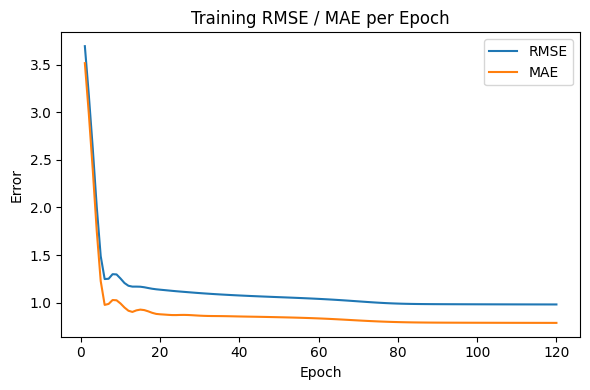

[run-once] Train-set  RMSE=0.9801 | MAE=0.7863
Train  RMSE=0.9801 | MAE=0.7863
Test   RMSE=0.9811 | MAE=0.7864

—— 50 % train ——
[run-once] cfg → Config(num_users=6040, num_items=3952, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(31,), batch_grid=(32, 64, 128, 256, 512), latent_dim=31, eta=1.0, batch_size=128, lr=0.00123, hidden_dims=(128, 64), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-2.4236e-09, -3.2920e-08,  9.7919e-02,  ..., -6.0798e-03,
         -1.2607e-02,  1.0676e-02],
        [ 1.5468e-08, -6.3192e-02, -5.0762e-03,  ..., -1.3832e-02,
         -1.1467e-02, -1.6619e-02],
        [ 9.8468e-09,  4.8481e-08, -1.4896e-07,  ..., -4.2797e-03,
         -8.2907e-03, -7.1798e-03],
        ...,
        [ 5.7977e-08,  7.3009e-08,  8.1239e-09,  ..., -4.6722e-03,
         -6.8064e-03, -1.5921e-02],
        [ 4.2795e-09,  4.1708e-08, -1.2198e-07,  ..., -4.5337e-03,
         -6.6446e-03, -1.6020e-02],
     

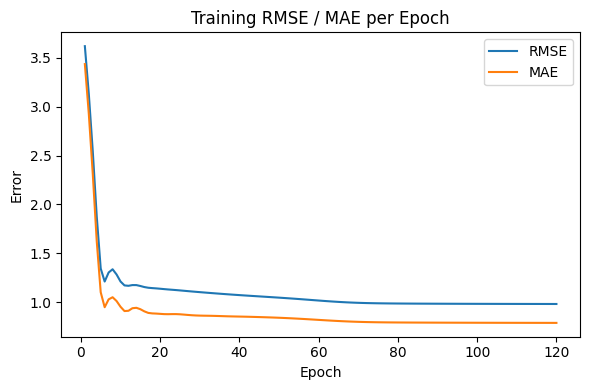

[run-once] Train-set  RMSE=0.9810 | MAE=0.7876
Train  RMSE=0.9810 | MAE=0.7876
Test   RMSE=0.9840 | MAE=0.7897

—— 30 % train ——
[run-once] cfg → Config(num_users=6040, num_items=3952, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(31,), batch_grid=(32, 64, 128, 256, 512), latent_dim=31, eta=1.0, batch_size=128, lr=0.00123, hidden_dims=(128, 64), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-2.4236e-09, -3.2920e-08,  9.7919e-02,  ..., -6.0798e-03,
         -1.2607e-02,  1.0676e-02],
        [ 1.5468e-08, -6.3192e-02, -5.0762e-03,  ..., -1.3832e-02,
         -1.1467e-02, -1.6619e-02],
        [ 9.8468e-09,  4.8481e-08, -1.4896e-07,  ..., -4.2797e-03,
         -8.2907e-03, -7.1798e-03],
        ...,
        [ 5.7977e-08,  7.3009e-08,  8.1239e-09,  ..., -4.6722e-03,
         -6.8064e-03, -1.5921e-02],
        [ 4.2795e-09,  4.1708e-08, -1.2198e-07,  ..., -4.5337e-03,
         -6.6446e-03, -1.6020e-02],
     

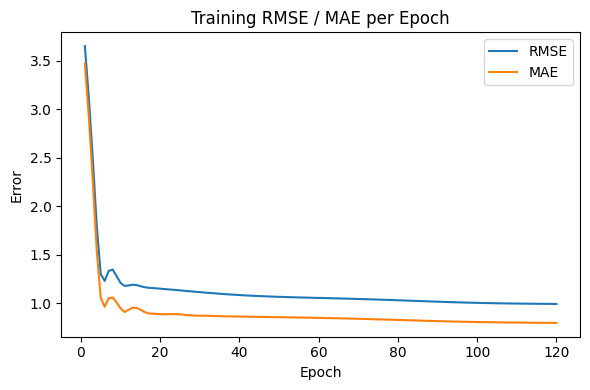

[run-once] Train-set  RMSE=0.9931 | MAE=0.7980
Train  RMSE=0.9931 | MAE=0.7980
Test   RMSE=0.9985 | MAE=0.8022


In [ ]:
# =============================================================
# MovieLens-1M   |   70% / 50% / 30% train  (RMSE & MAE)
# =============================================================
from pathlib import Path
import pandas as pd, numpy as np, torch, zipfile, re

# ---------- 0)  unzip --------------------------------------------------------
BASE = Path("/content/drive/MyDrive/Colab Notebooks/bigdata/project")
zip_path, data_dir = BASE / "ml-1m.zip", BASE / "ml-1m"
if not data_dir.exists():
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(BASE)
print("✓ MovieLens-1M extracted")

# ---------- 1) ratings.dat  -------------------------------------------------
ratings = pd.read_csv(data_dir / "ratings.dat", sep="::", engine="python",
                      names=["user","item","rating","ts"])
ratings[["user","item"]] -= 1

n_users = ratings.user.nunique()

# ---------- 2) movies.dat  ---------------------------------------------------
movies = pd.read_csv(
    data_dir / "movies.dat", sep="::", engine="python",
    encoding="ISO-8859-1",
    names=["item_id","title","genres"]
)
movies["item_id"] -= 1
movies["year"] = (
    movies["title"].str.extract(r"\((\d{4})\)", expand=False)
    .astype(float).fillna(1990).astype(int)
)

n_items = movies.item_id.max() + 1        # ← 3952 (FULL catalog)
print(f"Users={n_users} | Items(all)={n_items} | Ratings={len(ratings)}")

# ---------- one-hot genre matrix  (G)  --------------------------
all_genres = sorted({g for lst in movies.genres.str.split('|') for g in lst})
G = np.zeros((n_items, len(all_genres)), np.float32)
for iid, genres in zip(movies.item_id, movies.genres.str.split('|')):
    for g in genres:
        G[iid, all_genres.index(g)] = 1

# ---------- one-hot 7-year-bin matrix  (Yr)  --------------------
def ybin(y, base=1910, span=7): return (y - base) // span
Yr = np.zeros((n_items, ybin(movies.year).max() + 1), np.float32)
for iid, yr in zip(movies.item_id, movies.year):
    Yr[iid, ybin(yr)] = 1

# ---------- **NOW** build the raw attribute matrix  C  ----------
C = np.hstack([G, Yr])          #  (3952 , 32)
print("C built:", C.shape)



# ---------- orthogonalise  ---------------------------------------------------
Q,_ = np.linalg.qr(C + 1e-6*np.random.randn(*C.shape))
VA  = torch.tensor(Q.astype(np.float32))
d_aux = VA.shape[1]

# ---------- build triples & dense matrix  ------------------------------------
triples = list(zip(ratings.user, ratings.item, ratings.rating))

full_ds = RatingDataset(triples, num_users=n_users, num_items=n_items)

dense = torch.zeros(full_ds.num_users, n_items)
for u,i,r in triples: dense[u,i] = r

def split_and_run(train_frac:float, seed:int=42):
    print(f"\n—— {int(train_frac*100)} % train ——")

    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(full_ds))
    k    = int(train_frac * len(full_ds))
    tr = RatingDataset([full_ds.triples[i] for i in perm[:k]],
                       full_ds.num_users, full_ds.num_items)
    te = RatingDataset([full_ds.triples[i] for i in perm[k:]],
                       full_ds.num_users, full_ds.num_items)

    cfg0 = Config(
        num_users = tr.num_users,
        num_items = tr.num_items,
        aux_va    = VA,
        latent_dim = d_aux,
        dim_grid   = (d_aux,),   # keep latent-dim fixed
        epochs     = 120 ,         # ← run DMF / FSTDMF for 30 epochs
        batch_size = 128
    )


    cfg, model, V, rmse_tr, mae_tr = run_once(cfg0, tr, dense)
    rmse_te, mae_te = rmse, mae = evaluate_metrics(model, te)    #  ← همان نکته، بدون V
  # ⬅️ now passes V

    #print(f"\n—— {int(train_frac*100)} % train ——")
    print(f"Train  RMSE={rmse_tr:.4f} | MAE={mae_tr:.4f}")
    print(f"Test   RMSE={rmse_te:.4f} | MAE={mae_te:.4f}")

# ---------- 5)  run three splits ---------------------------------------------
for frac in (0.7, 0.5, 0.3):
    split_and_run(frac)


# Movielense_1M- Movilense_100k

In [ ]:
"""
Feature Subspace Transfer Deep Matrix Factorization (FSTDMF)
------------------------------------------------------------
Full implementation + helpers + optional grid-search.
Now logs **RMSE and MAE** everywhere.
"""

from __future__ import annotations
import math, random, dataclasses
from dataclasses import dataclass
from typing import Iterable, List, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────
# 1) DATA HELPERS
# ──────────────────────────────────────────────────────────────
def _build_index(triples:Iterable[Tuple[int,int,float]]):
    users,items=zip(*[(u,i) for u,i,_ in triples]); return max(users)+1,max(items)+1

class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, triples:List[Tuple[int,int,float]],
                 num_users:int|None=None, num_items:int|None=None):
        self.triples=triples
        self.num_users,self.num_items= ( _build_index(triples) if num_users is None else (num_users,num_items) )
    def __len__(self): return len(self.triples)
    def __getitem__(self,idx:int):
        u,i,r=self.triples[idx]
        return (torch.tensor(u,dtype=torch.long),
                torch.tensor(i,dtype=torch.long),
                torch.tensor(r,dtype=torch.float32))

def batchify(loader, device=DEVICE):
    for u,i,r in loader:
        yield u.to(device), i.to(device), r.to(device)

# ──────────────────────────────────────────────────────────────
# 2) CONFIG
# ──────────────────────────────────────────────────────────────
@dataclass(slots=True)
class Config:
    num_users:int; num_items:int
    lr_grid:Tuple[float,...]=(0.0123,0.00123)
    eta_grid:Tuple[float,...]=(0.10,0.15,0.20,0.25,0.30,0.35,0.40)
    dim_grid:Tuple[int,...]=(100,300,500)


    latent_dim:int=100; eta:float=1.0; batch_size:int=128; lr:float=0.0123
    hidden_dims:Tuple[int,int]=(256,128)
    beta:float=0.1; alpha:float=0.10
    epochs_pretrain:int=40; epochs:int=120; lr_pretrain:float=1e-3
    aux_va:torch.Tensor|None=None
    def copy(self,**kw): d=dataclasses.asdict(self); d.update(kw); return Config(**d)

# ──────────────────────────────────────────────────────────────
# 3) MODELS
# ──────────────────────────────────────────────────────────────
class SemiAutoEncoder(nn.Module):
    def __init__(self,input_dim:int, latent_dim:int, hidden_dim:int|None=None):
        super().__init__()
        hidden_dim=hidden_dim or latent_dim*2
        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim), nn.Sigmoid(),
                                   nn.Linear(hidden_dim,latent_dim))
        self.decoder=nn.Linear(latent_dim,input_dim)
    def forward(self,x):
        z=self.encoder(x); x_hat=self.decoder(z); return x_hat,z

class DeepMF(nn.Module):
    def __init__(self,cfg:Config):
        super().__init__()
        self.user=nn.Embedding(cfg.num_users,cfg.latent_dim)
        self.item=nn.Embedding(cfg.num_items,cfg.latent_dim)
        dims=[cfg.latent_dim*2]+list(cfg.hidden_dims)+[1]
        layers=[]
        for d_in,d_out in zip(dims[:-1],dims[1:]):
            layers.append(nn.Linear(d_in,d_out));
            if d_out!=1: layers.append(nn.Tanh())
        self.mlp=nn.Sequential(*layers)
    def forward(self,u,i):
        u_vec=self.user(u); v_vec=self.item(i)
        pred=self.mlp(torch.cat([u_vec,v_vec],-1)).squeeze(-1)
        return pred,u_vec,v_vec

class FSTDMF(nn.Module):
    def __init__(self, cfg: Config, n_ratings: int, V_init: torch.Tensor | None = None):
        super().__init__()
        self.cfg = cfg
        self.dmf = DeepMF(cfg)
        self.n = n_ratings
        if V_init is not None:
            with torch.no_grad():
                self.dmf.item.weight.copy_(V_init)
        if cfg.aux_va is not None:
            self.register_buffer("aux_va", cfg.aux_va)
            self.register_buffer("P_aux", self.aux_va @ self.aux_va.T)
        else:
            self.aux_va = None
            self.P_aux = None

    def rec_loss(self,pred_full, target_full, mask):
        return ((pred_full - target_full) * mask).pow(2).sum() / (2 * mask.shape[0])  # normalize by n_items

    def l2_loss(self, V):
        loss_V = (self.cfg.alpha / (2 * self.n)) * V.pow(2).sum()
        loss_W = (self.cfg.beta / 2) * sum(p.pow(2).sum() for p in self.parameters())
        return loss_V + loss_W

    def sub_loss(self, V):
        if self.aux_va is None:
            return torch.tensor(0., device=V.device)
        proj = self.P_aux @ V
        return -(self.cfg.alpha * self.cfg.eta) / (2 * self.n) * proj.pow(2).sum()

    def total_loss(self, R_hat, R_full, mask, V):
        return self.rec_loss(R_hat, R_full, mask) + self.sub_loss(V) + self.l2_loss(V)

    def forward(self, V):
        # Full prediction matrix R_hat ∈ [n_items, n_users]
        U = self.dmf.user.weight           # [n_users, d]
        I = self.dmf.item.weight           # [n_items, d]
        all_u = U.unsqueeze(0).expand(I.shape[0], -1, -1)  # [n_items, n_users, d]
        all_i = I.unsqueeze(1).expand(-1, U.shape[0], -1)  # [n_items, n_users, d]
        concat = torch.cat([all_u, all_i], dim=-1)         # [n_items, n_users, 2d]
        R_hat = self.dmf.mlp(concat).squeeze(-1)           # [n_items, n_users]
        return R_hat




# ──────────────────────────────────────────────────────────────
# 4) TRAIN / EVAL (RMSE & MAE)   <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _epoch_metrics(se_sum:float, ae_sum:float, n:int)->Tuple[float,float]:
    rmse=math.sqrt(se_sum/n); mae=ae_sum/n; return rmse,mae

def pretrain_semiautoencoder(cfg:Config, dense:torch.Tensor):
    sa=SemiAutoEncoder(cfg.num_users,cfg.latent_dim,cfg.latent_dim*2).to(DEVICE)
    opt=torch.optim.Adam(sa.parameters(), lr=cfg.lr_pretrain)
    X=dense.to(DEVICE)
    for ep in range(cfg.epochs_pretrain):
        opt.zero_grad(); x_hat,_=sa(X.T)
        loss=F.mse_loss(x_hat,X.T); loss.backward(); opt.step()
        if (ep+1)%10==0: print(f"[SA] Ep {ep+1}/{cfg.epochs_pretrain}  Loss={loss.item():.4f}")
    with torch.no_grad(): _ ,V=sa(X.T); return V.cpu()


def train_fstdmf(cfg: Config, ds: RatingDataset, V_init: torch.Tensor | None):
    model = FSTDMF(cfg, len(ds), V_init).to(DEVICE)
    V = nn.Parameter(V_init.clone().to(DEVICE))  # ← make item embeddings a parameter
    opt = torch.optim.Rprop([*model.parameters(), V], lr=cfg.lr,
                            etas=(0.5, 1.2), step_sizes=(1e-6, 50))

    # Build full rating matrix and mask
    R_full = torch.zeros(cfg.num_items, cfg.num_users, device=DEVICE)
    mask_tr = torch.zeros_like(R_full)
    for u, i, r in ds.triples:
        R_full[i, u] = r
        mask_tr[i, u] = 1.0

    rmses, maes = [], []
    for ep in range(cfg.epochs):
        model.train(); opt.zero_grad()
        model.dmf.item.weight = V  # tie to parameter

        R_hat = model(V)
        loss = model.total_loss(R_hat, R_full, mask_tr, V)
        loss.backward(); opt.step()

        # Metrics
        se = ((R_hat - R_full) * mask_tr).pow(2).sum().item()
        ae = ((R_hat - R_full).abs() * mask_tr).sum().item()
        n = mask_tr.sum().item()
        rmse, mae = _epoch_metrics(se, ae, n)
        rmses.append(rmse); maes.append(mae)

        if (ep + 1) % 10 == 0:
            print(f"[FSTDMF] Ep {ep + 1}/{cfg.epochs}  RMSE≈{rmse:.4f} | MAE≈{mae:.4f}")

    # Plot
    plt.figure()
    plt.plot(range(1, cfg.epochs + 1), rmses, label="RMSE")
    plt.plot(range(1, cfg.epochs + 1), maes, label="MAE")
    plt.xlabel("Epoch"); plt.ylabel("Error")
    plt.title("Training RMSE and MAE per Epoch")
    plt.legend(); plt.show()


    return model, V


@torch.no_grad()
def evaluate_metrics(model: FSTDMF, ds: RatingDataset, V: torch.Tensor) -> Tuple[float, float]:
    model.eval()
    R_hat = model(V.to(DEVICE))  # shape [n_items, n_users]
    se, ae, n = 0., 0., 0
    for u, i, r in ds.triples:
        pred = R_hat[i, u].item()
        se += (pred - r) ** 2
        ae += abs(pred - r)
        n += 1
    return _epoch_metrics(se, ae, n)


# ──────────────────────────────────────────────────────────────
# 5) SINGLE RUN  (random or fixed)  <-- CHANGED -->
# ──────────────────────────────────────────────────────────────
def _pick(t): return random.choice(t)
def run_once(cfg_base: Config, ds: RatingDataset, dense: torch.Tensor,
             cfg_override: Config | None = None):
    cfg = cfg_override or cfg_base.copy(
        lr=_pick(cfg_base.lr_grid),
        eta=1.0,
        batch_size=128
    )
    print(f"[run-once] cfg → {cfg}")
    V_init = pretrain_semiautoencoder(cfg, dense)
    model, V = train_fstdmf(cfg, ds, V_init)  # ⬅️ return both model and final V

    rmse, mae = evaluate_metrics(model, ds, V)
    print(f"[run-once] Train-set  RMSE={rmse:.4f} | MAE={mae:.4f}")
    return cfg, model, V, rmse, mae





✓ ml-100k extracted
✓ ml-1m extracted
✓ common movies = 1546
[SA] Ep 10/40  Loss=0.5974
[SA] Ep 20/40  Loss=0.5304
[SA] Ep 30/40  Loss=0.4982
[SA] Ep 40/40  Loss=0.4741
✓ VA shape = torch.Size([1546, 300])

=== split 70% train  ===
[run-once] cfg → Config(num_users=943, num_items=1546, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(300,), latent_dim=300, eta=1.0, batch_size=128, lr=0.00123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-0.0697, -0.0217,  0.0094,  ...,  0.0193, -0.0376,  0.0325],
        [-0.0639, -0.0048,  0.0216,  ..., -0.0362,  0.0137,  0.0068],
        [-0.0345, -0.0109, -0.0327,  ..., -0.0231, -0.0029,  0.0379],
        ...,
        [-0.0103,  0.0334,  0.0553,  ...,  0.0275, -0.0049,  0.0119],
        [-0.0222,  0.0022,  0.0015,  ...,  0.0183,  0.0043,  0.0264],
        [-0.0363,  0.0329,  0.0002,  ...,  0.0296, -0.0308, -0.0155]]))
[SA] Ep 10/40  Loss=0.6641
[S

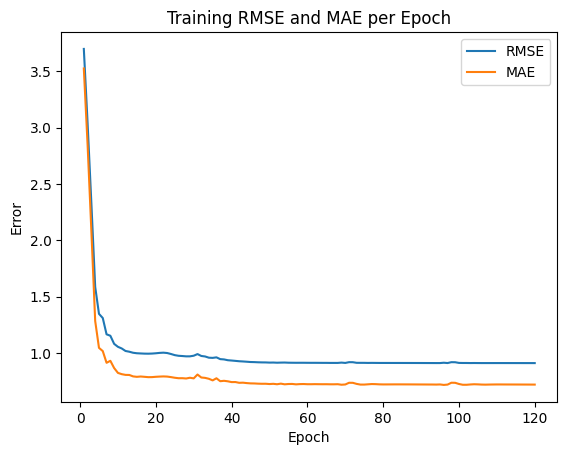

[run-once] Train-set  RMSE=0.9085 | MAE=0.7174
Train  RMSE=0.9085 | MAE=0.7174
Test   RMSE=0.9399 | MAE=0.7415

=== split 50% train  ===
[run-once] cfg → Config(num_users=943, num_items=1546, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(300,), latent_dim=300, eta=1.0, batch_size=128, lr=0.00123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-0.0697, -0.0217,  0.0094,  ...,  0.0193, -0.0376,  0.0325],
        [-0.0639, -0.0048,  0.0216,  ..., -0.0362,  0.0137,  0.0068],
        [-0.0345, -0.0109, -0.0327,  ..., -0.0231, -0.0029,  0.0379],
        ...,
        [-0.0103,  0.0334,  0.0553,  ...,  0.0275, -0.0049,  0.0119],
        [-0.0222,  0.0022,  0.0015,  ...,  0.0183,  0.0043,  0.0264],
        [-0.0363,  0.0329,  0.0002,  ...,  0.0296, -0.0308, -0.0155]]))
[SA] Ep 10/40  Loss=0.6629
[SA] Ep 20/40  Loss=0.5897
[SA] Ep 30/40  Loss=0.5424
[SA] Ep 40/40  Loss=0.5112
[FSTDMF] Ep 10/1

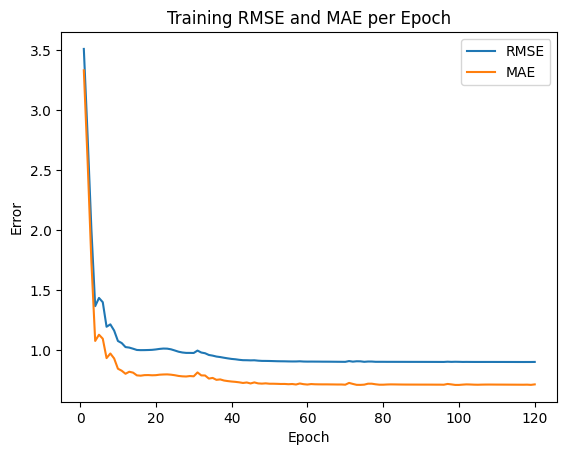

[run-once] Train-set  RMSE=0.9011 | MAE=0.7121
Train  RMSE=0.9011 | MAE=0.7121
Test   RMSE=0.9464 | MAE=0.7472

=== split 30% train  ===
[run-once] cfg → Config(num_users=943, num_items=1546, lr_grid=(0.0123, 0.00123), eta_grid=(0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4), dim_grid=(300,), latent_dim=300, eta=1.0, batch_size=128, lr=0.0123, hidden_dims=(256, 128), beta=0.1, alpha=0.1, epochs_pretrain=40, epochs=120, lr_pretrain=0.001, aux_va=tensor([[-0.0697, -0.0217,  0.0094,  ...,  0.0193, -0.0376,  0.0325],
        [-0.0639, -0.0048,  0.0216,  ..., -0.0362,  0.0137,  0.0068],
        [-0.0345, -0.0109, -0.0327,  ..., -0.0231, -0.0029,  0.0379],
        ...,
        [-0.0103,  0.0334,  0.0553,  ...,  0.0275, -0.0049,  0.0119],
        [-0.0222,  0.0022,  0.0015,  ...,  0.0183,  0.0043,  0.0264],
        [-0.0363,  0.0329,  0.0002,  ...,  0.0296, -0.0308, -0.0155]]))
[SA] Ep 10/40  Loss=0.6678
[SA] Ep 20/40  Loss=0.5961
[SA] Ep 30/40  Loss=0.5466
[SA] Ep 40/40  Loss=0.5140
[FSTDMF] Ep 10/12

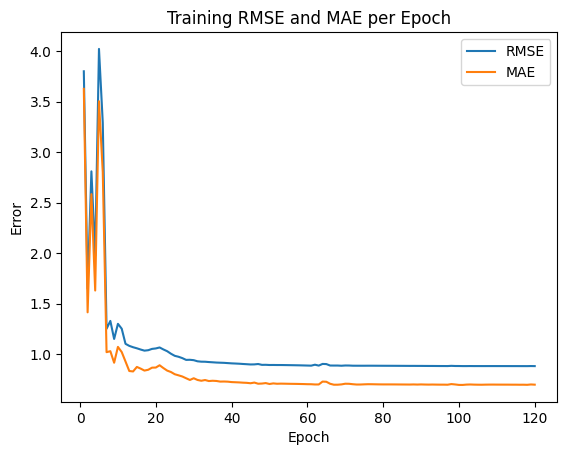

[run-once] Train-set  RMSE=0.8828 | MAE=0.6968
Train  RMSE=0.8828 | MAE=0.6968
Test   RMSE=0.9592 | MAE=0.7566


In [ ]:
# ============================================================
# MovieLens-100K  +  MovieLens-1M  |  Task-1 overlap only
# ============================================================
from pathlib import Path
import pandas as pd, numpy as np, torch, zipfile, math, random

BASE = Path("/content/drive/MyDrive/Colab Notebooks/bigdata/project")

# ---------- 0) extract BOTH datasets (100K and 1M) ---------------------------
for name in ("ml-100k", "ml-1m"):
    z = BASE / f"{name}.zip"
    d = BASE / name
    if not d.exists():
        with zipfile.ZipFile(z) as zf:
            zf.extractall(BASE)
    print(f"✓ {name} extracted")

# ---------- 1) load MovieLens-1M ratings ------------------------------------
r1m = pd.read_csv(
    BASE / "ml-1m" / "ratings.dat",
    sep="::", engine="python",
    names=["user", "item", "rating", "ts"]
)
r1m[["user", "item"]] -= 1               # zero-index

# ---------- 2) load MovieLens-100K ratings ----------------------------------
r100k = pd.read_csv(
    BASE / "ml-100k" / "u.data",
    sep="\t",
    names=["user", "item", "rating", "ts"]
)
r100k[["user", "item"]] -= 1             # zero-index

# ---------- 3) keep the INTERSECTION of items -------------------------------
common_items = np.intersect1d(r1m.item.unique(), r100k.item.unique())
item_map = {old_i: new_i for new_i, old_i in enumerate(common_items)}
n_items_comm = len(common_items)
print(f"✓ common movies = {n_items_comm}")     # → 1 546

# remap MovieLens-1M items
r1m = r1m[r1m.item.isin(common_items)].copy()
r1m["item_mapped"] = r1m.item.map(item_map)

# remap MovieLens-100K items  (this is the TARGET domain!)
r100k = r100k[r100k.item.isin(common_items)].copy()
r100k["item_mapped"] = r100k.item.map(item_map)

# ---------- 4) dense user × item matrices -----------------------------------
# 4-a) 1M (source) – used to build VA
n_users_src = r1m.user.max() + 1
dense_src = torch.zeros(n_users_src, n_items_comm, dtype=torch.float32)
for u, i, r in zip(r1m.user, r1m.item_mapped, r1m.rating):
    dense_src[u, i] = r

# 4-b) 100K (target) – used for training / evaluation
n_users_tgt = r100k.user.max() + 1
dense_tgt = torch.zeros(n_users_tgt, n_items_comm, dtype=torch.float32)
for u, i, r in zip(r100k.user, r100k.item_mapped, r100k.rating):
    dense_tgt[u, i] = r

# ---------- 5) build auxiliary matrix VA from the 1M side --------------------
latent_dim_aux = 300                       # 300 or 500 -- match the paper
cfg_aux = Config(num_users=n_users_src,
                 num_items=n_items_comm,
                 latent_dim=latent_dim_aux)
Z_aux = pretrain_semiautoencoder(cfg_aux, dense_src)   # [n_items, d]

# orthogonalise
Q, _ = torch.linalg.qr(
    Z_aux + 1e-6 * torch.randn_like(Z_aux)  # tiny noise to avoid rank issues
)
VA = Q.cpu()                                # final   V_A ∈ ℝⁿ×ᵈ
d_aux = VA.shape[1]
print(f"✓ VA shape = {VA.shape}")            # (1546, 300)

# ---------- 6) triples + RatingDataset objects ------------------------------
triples_all = list(zip(r100k.user, r100k.item_mapped, r100k.rating))
full_ds = RatingDataset(triples_all, n_users_tgt, n_items_comm)

# ---------- helper: create split, run model, print metrics -------------------
def run_fraction(train_frac: float, seed: int = 42):
    print(f"\n=== split {int(train_frac * 100)}% train  ===")
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(full_ds))
    k = int(train_frac * len(full_ds))
    tr_idx, te_idx = perm[:k], perm[k:]

    tr = RatingDataset([full_ds.triples[i] for i in tr_idx],
                       full_ds.num_users, full_ds.num_items)
    te = RatingDataset([full_ds.triples[i] for i in te_idx],
                       full_ds.num_users, full_ds.num_items)

    cfg0 = Config(num_users=tr.num_users,
                  num_items=tr.num_items,
                  aux_va=VA,              # ← new latent auxiliary matrix
                  latent_dim=d_aux,       # ← matches VA columns
                  dim_grid=(d_aux,))      # (optional) lock grid-search

    cfg, model, V, rmse_tr, mae_tr = run_once(cfg0, tr, dense_tgt)
    rmse_te, mae_te = evaluate_metrics(model, te, V)

    print(f"Train  RMSE={rmse_tr:.4f} | MAE={mae_tr:.4f}")
    print(f"Test   RMSE={rmse_te:.4f} | MAE={mae_te:.4f}")
    return (rmse_te, mae_te)

# ---------- 7) run for 70 %, 50 %, 30 % --------------------------------------
for frac in (0.7, 0.5, 0.3):
    run_fraction(frac)
